In [1]:
import pandas as pd
import datetime as dt
import backtrader as bt
import quantstats as qs
import matplotlib as plt
import numpy as np
import os

os.getcwd()

#数据加载-------------------------------------
df=pd.read_csv(r'C:\Users\31145\PycharmProjects\Backtrader学习\CSI300.csv')#绝对路径
df.index=pd.to_datetime(df.date)
df['openinterest']=0

#以下是自己随机添加signal的之后的文件，hmm算法给出的带signal的文件直接用上面的df=pd.read_csv导入，把下面到构建策略之前mute掉即可

#随机生成一个-1，0，1的predictions序列---------
sig=[]
for i in range(len(df)):
    x=np.random.randn()
    if x > 0.2:
        sig.append(1)
    elif x<-0.2:
        sig.append(-1)
    else:
        sig.append(0)
df['signal']=sig



#构建策略-------------------------------------
class TestSignalStrategy(bt.Strategy):
    params=()

    def log(self,txt,dt=None):
        dt= dt or self.datas[0].datetime.date(0)
        print('%s,%s' % (dt.isoformat(),txt)) 

    def __init__(self):
        self.bar_num=0
        self.signal_df=df
        self.signal_df['date']=pd.to_datetime(self.signal_df['date'])
        self.first_trade=True

    def prenext(self):
        self.next()

    def next(self):
        self.bar_num+=1
        current_date=self.datas[0].datetime.date(0).strftime("%Y-%m-%d")
        try:
            next_date =self.datas[0].datetime.date(1)
        except:
            next_date=None
        if next_date != None:
            next_signal_df= self.signal_df[self.signal_df['date']==pd.to_datetime(next_date)]
            if len(next_signal_df)==0:
                self.log("下个交易日的信号不存在")
            else:
                signal = int(next_signal_df['signal'])
                
                #第一次交易没有底仓，只允许做多
                #交易信号的执行方式：
                #先不考虑卖空
                #signal为1，以当天开盘价全仓买入
                #signal为-1时，以当天开盘价卖出所有持仓
                if self.first_trade:
                    if signal==-1:
                        pass
                    if signal == 1:
                        total_value = self.broker.get_value()
                        open_price = self.datas[0].open[0]
                        target_size=total_value//open_price
                        self.buy(self.datas[0],size=target_size,price=open_price)
                        self.first_trade=False
                else:
                    #现有持仓
                    now_hold_size = self.getposition(self.datas[0]).size
                    if signal == 1:
                        total_value = self.broker.get_value()
                        open_price = self.datas[0].open[0]
                        target_size=total_value//open_price
                        self.buy(self.datas[0],size=target_size, price=open_price)

                    if signal == -1:
                        total_value = self.broker.get_value()
                        open_price = self.datas[0].open[0]
                        target_size=total_value//open_price
                        #卖出开仓，手数不能超过底仓
                        if target_size>now_hold_size:
                            target_size=now_hold_size

                        self.sell(self.datas[0],size=target_size, price=open_price)

    #订单情况
    def notify_order(self, order):
        
        #订单处于未决，继续
        if order.status in [order.Submitted, order.Accepted]:
            return
        
        #订单已决
        if order.status in [order.Completed]:
            if order.isbuy():
                self.log('买单执行,%.2f' % order.executed.price)

            elif order.issell():
                self.log('卖单执行,%2f' % order.executed.price)
        
        elif order.status in [order.Canceled,order.Rejected,order.Expired]:
            self.log('订单 Canceled/Rejected/Expired')

    #交易情况
    def notify_trade(self, trade):
        if trade.isclosed:
            print('毛收益 %0.2f, 扣佣后收益 % 0.2f , 佣金 %.2f'
            % (trade.pnl, trade.pnlcomm, trade.commission))
        


cerebro=bt.Cerebro()

stock_df=df[['open','high','low','close','volume','openinterest']]
data=bt.feeds.PandasData(dataname=stock_df,fromdate=dt.datetime(2010,1,4),todate=dt.datetime(2021,12,31),timeframe=bt.TimeFrame.Days)
cerebro.adddata(data)

#初始资金设置为10万
cerebro.broker.setcash(100000.0)
#手续费万分之二
cerebro.broker.setcommission(commission=0.0002)
#滑点设置 0.5%
cerebro.broker = bt.brokers.BackBroker(slip_perc=0.005)

cerebro.addstrategy(TestSignalStrategy)
cerebro.addanalyzer(bt.analyzers.PyFolio,_name='PyFolio')

#运行回测
print('start portfolio value:',format(cerebro.broker.getvalue()))
results = cerebro.run()
print('end portfolio value:',format(cerebro.broker.getvalue()))


#绩效评价----------------------------
#获取策略实例
start = results[0]
portfolio_stats = start.analyzers.getbyname('PyFolio')
#以下returns为以日期为索引的资产日收益率序列
returns,positions,transactions,gross_lev = portfolio_stats.get_pf_items()
returns.index = returns.index.tz_convert(None)


start portfolio value: 10000.0
2010-01-05,买单执行,3545.19
2010-01-06,卖单执行,3558.700000
毛收益 27.02, 扣佣后收益  27.02 , 佣金 0.00
2010-01-08,买单执行,3456.91
2010-01-15,卖单执行,3472.520000
毛收益 31.22, 扣佣后收益  31.22 , 佣金 0.00
2010-01-21,买单执行,3397.04
2010-01-22,卖单执行,3364.450000
毛收益 -65.18, 扣佣后收益 -65.18 , 佣金 0.00
2010-01-25,买单执行,3340.01
2010-01-26,卖单执行,3328.110000
毛收益 -23.80, 扣佣后收益 -23.80 , 佣金 0.00
2010-01-29,买单执行,3190.32
2010-02-01,卖单执行,3198.230000
毛收益 23.73, 扣佣后收益  23.73 , 佣金 0.00
2010-02-02,买单执行,3170.78
2010-02-03,卖单执行,3160.710000
毛收益 -30.21, 扣佣后收益 -30.21 , 佣金 0.00
2010-02-04,买单执行,3206.43
2010-02-08,卖单执行,3152.250000
毛收益 -162.54, 扣佣后收益 -162.54 , 佣金 0.00
2010-02-10,买单执行,3195.14
2010-02-22,卖单执行,3248.950000
毛收益 161.43, 扣佣后收益  161.43 , 佣金 0.00
2010-02-26,买单执行,3286.09
2010-03-01,卖单执行,3290.010000
毛收益 11.76, 扣佣后收益  11.76 , 佣金 0.00
2010-03-08,买单执行,3268.40
2010-03-11,卖单执行,3282.200000
毛收益 41.40, 扣佣后收益  41.40 , 佣金 0.00
2010-03-12,买单执行,3277.31
2010-03-15,卖单执行,3231.220000
毛收益 -138.27, 扣佣后收益 -138.27 , 佣金 0.00
2010-03-16,买

                    Strategy
------------------  ----------
Start Period        2010-01-04
End Period          2021-12-31
Risk-Free Rate      0.0%
Time in Market      72.0%

Cumulative Return   240.09%
CAGR﹪              10.74%

Sharpe              0.82
Sortino             1.26
Sortino/√2          0.89
Omega               1.21

Max Drawdown        -15.8%
Longest DD Days     981

Gain/Pain Ratio     0.21
Gain/Pain (1M)      0.96

Payoff Ratio        1.15
Profit Factor       1.21
Common Sense Ratio  1.49
CPC Index           0.71
Tail Ratio          1.24
Outlier Win Ratio   6.95
Outlier Loss Ratio  4.05

MTD                 -0.38%
3M                  0.68%
6M                  -2.52%
YTD                 3.82%
1Y                  3.99%
3Y (ann.)           16.1%
5Y (ann.)           9.52%
10Y (ann.)          12.35%
All-time (ann.)     10.74%

Avg. Drawdown       -2.78%
Avg. Drawdown Days  51
Recovery Factor     15.19
Ulcer Index         0.06
Serenity Index      3.81


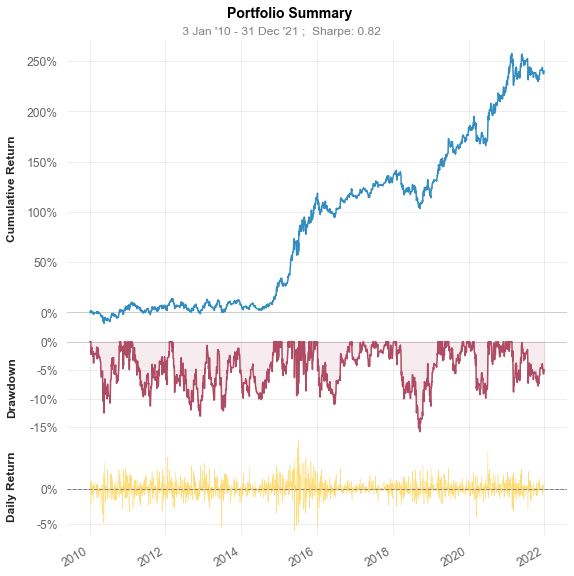

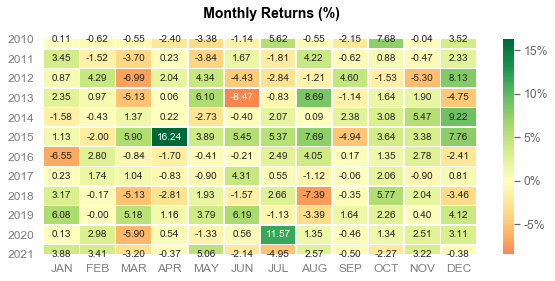

In [2]:
#画图仍只能在notebook中输出(将basic改成full的话可以得到更多的输出结果，但其中一个return distribution的表会报错)
qs.reports.basic(returns,benchmark=None,rf=0.0,grayscale=False,display=True,compounded = True)

                           Strategy
-------------------------  ----------
Start Period               2010-01-04
End Period                 2021-12-31
Risk-Free Rate             0.0%
Time in Market             72.0%

Cumulative Return          240.09%
CAGR﹪                     10.74%

Sharpe                     0.82
Smart Sharpe               0.81
Sortino                    1.26
Smart Sortino              1.24
Sortino/√2                 0.89
Smart Sortino/√2           0.88
Omega                      1.21

Max Drawdown               -15.8%
Longest DD Days            981
Volatility (ann.)          14.11%
Calmar                     0.68
Skew                       0.42
Kurtosis                   9.03

Expected Daily %           0.04%
Expected Monthly %         0.85%
Expected Yearly %          10.74%
Kelly Criterion            8.76%
Risk of Ruin               0.0%
Daily Value-at-Risk        -1.42%
Expected Shortfall (cVaR)  -1.42%

Gain/Pain Ratio            0.21
Gain/Pain (1M)             0

None

,Start,Valley,End,Days,Max Drawdown,99% Max Drawdown
1,2018-02-06,2018-09-18,2019-03-12,399,-15.802016,-15.521663
2,2012-03-06,2012-11-28,2014-11-12,981,-13.061153,-12.166911
3,2010-01-13,2010-05-18,2010-10-19,279,-12.515025,-12.417510
4,2011-02-11,2011-08-08,2012-02-08,362,-11.324980,-9.685759
5,2016-01-07,2016-06-15,2016-11-25,323,-11.013284,-10.621683


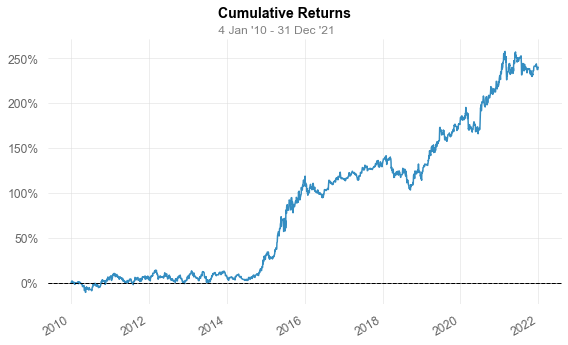

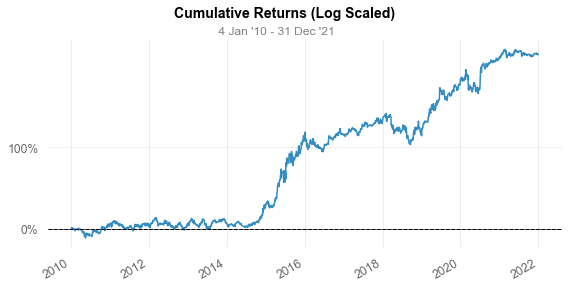

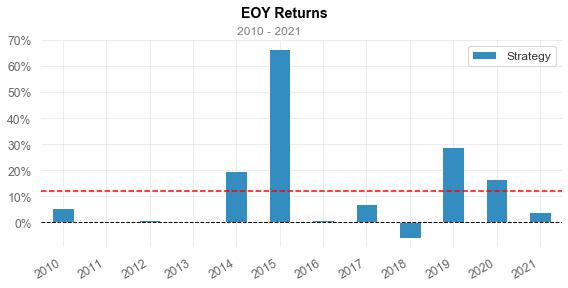

AttributeError: module 'seaborn' has no attribute 'histplot'

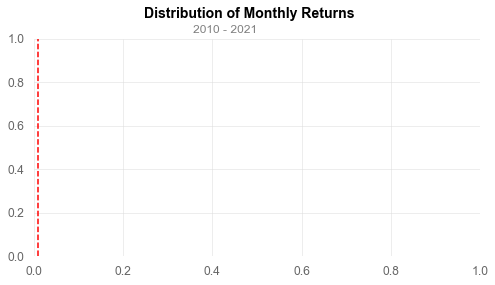

In [3]:
#画图仍只能在notebook中输出
qs.reports.full(returns,benchmark=None,rf=0.0,grayscale=False,display=True,compounded = True)